### Importação das bibliotecas

In [20]:
import pandas as pd
import numpy as np

### Importação da Database

In [21]:
df_escolas = pd.read_csv('db/escolas.csv', encoding='utf-8')
df_subprefeituras = pd.read_csv('db/subprefeituras.csv', encoding='utf-8')
df_material_didatico = pd.read_csv('db/material_didatico.csv', encoding='utf-8')

### Padronização dos dados

In [22]:
# Nome das colunas em snake_case
df_escolas.columns = df_escolas.columns.str.lower().str.strip().str.replace(' ', '_')
df_subprefeituras.columns = df_subprefeituras.columns.str.lower().str.strip().str.replace(' ', '_')
df_material_didatico.columns = df_material_didatico.columns.str.lower().str.strip().str.replace(' ', '_')

# Strings não devem conter acentos && Todas as strings devem estar em maiúsculo
df_escolas['escolas_postos'] = df_escolas['escolas_postos'].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
df_escolas['bairro'] = df_escolas['bairro'].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
df_escolas['endereço'] = df_escolas['endereço'].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
df_subprefeituras["nome"] = df_subprefeituras["nome"].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()
df_subprefeituras["subprefeitura"] = df_subprefeituras["subprefeitura"].str.normalize("NFKD").str.encode('ascii', errors='ignore').str.decode('utf-8').str.upper()

# Nome dos logradouros sem abreviação
df_escolas['endereço'] = df_escolas['endereço'].str.replace('R.', 'RUA', regex=False)
df_escolas['endereço'] = df_escolas['endereço'].str.replace('AV.', 'AVENIDA',regex=False)
df_escolas['endereço'] = df_escolas['endereço'].str.replace('PCA.', 'PRACA',regex=False)
df_escolas['endereço'] = df_escolas['endereço'].str.replace('ESTR.', 'ESTRADA',regex=False)

# Latitude e longitude com apenas 5 casas decimais, corrigindo dado linha 119 sem virgula
df_escolas['lat'] = df_escolas['lat'].apply(lambda x: x[:3] + ',' + x[3:] if len(x) >= 3 and x[3] != ',' else x)
df_escolas['lon'] = df_escolas['lon'].apply(lambda x: x[:3] + ',' + x[3:] if len(x) >= 3 and x[3] != ',' else x)
df_escolas["lat"] = df_escolas["lat"].str.replace(',','.',regex=False).astype(float).round(5)
df_escolas["lon"] = df_escolas["lon"].str.replace(',','.',regex=False).astype(float).round(5)

# Ids devem ser strings com 3 caracteres (Ex: '024')
df_escolas["id"] = df_escolas["id"].apply(lambda x: str(x).zfill(3))
df_material_didatico["id"] = df_material_didatico["id"].apply(lambda x: str(x).zfill(3))

# Visualização
df_escolas.head(30)
#df_material_didatico
#df_subprefeituras

,id,escolas_postos,bairro,endereço,lat,lon
0,178,CENTRO INTEGRADO DE EDUCACAO PUBLICA HENFIL,CAJU,RUA CARLOS SEIDL S/NO,-22.88089,-43.22533
1,634,EM ALICE DO AMARAL PEIXOTO,BENFICA,RUA EBANO 187,-22.88957,-43.23620
2,483,EM CELESTINO SILVA,CENTRO,"RUA DO LAVRADIO, 56",-22.90929,-43.18358
3,476,ESCOLA MUNICIPAL FLORIANO PEIXOTO,SAO CRISTOVAO,PRACA ARGENTINA 20,-22.89763,-43.22746
4,132,EM PEREIRA PASSOS,RIO COMPRIDO,PRACA CONDESSA PAULO DE FRONTIN 45,-22.92441,-43.20858
5,017,E.M PRESIDENTE JOSE LINHARES,IPANEMA,"RUA BARAO DA TORRE, 90",-22.98333,-43.19904
6,055,EM SANTA CATARINA,SANTA TERESA,RUA EDUARDO SANTOS 38,-22.91554,-43.19159
7,490,E.M TIA CIATA,CENTRO,AVENIDA PRESIDENTE VARGAS S/NO,-22.90712,-43.19507
8,600,EM URUGUAI,BENFICA,RUA ANA NERI 192,-22.89849,-43.23776
9,089,EM MARIO CLAUDIO,RIO COMPRIDO,"RUA HADDOCK LOBO, 148",-22.91723,-43.21104


### Dataframe Merged

In [23]:
# Merge 1 - df_escolas e df_material_didatico com base na coluna 'id'
merged_df = df_escolas.merge(df_material_didatico, on='id', how='left')

# Merge 2 - merged_df e df_subprefeituras com base na coluna 'bairro'
final_df = merged_df.merge(df_subprefeituras, left_on='bairro', right_on='nome', how='left')

# Colunas desejadas <<<--- adicionar aqui o tipo, nome escola, logradouro e numero quando separados
final_df = final_df[['id', 'bairro', 'subprefeitura', 'lat', 'lon', 'quantidade']] #falta criar o tipo, separar do nome da escola, criar o numero, separar do endereço

# Converte a coluna 'quantidade' para tipo numérico
final_df['quantidade'] = pd.to_numeric(final_df['quantidade'], errors='coerce') #The pd.to_numeric function with the errors='coerce' argument will convert any non-numeric values to NaN (Not-a-Number), allowing you to calculate the sum correctly.
print(final_df['quantidade'].sum())

# Display
#final_df.head(30)
print(merged_df.head(30))

43686.0
     id                               escolas_postos             bairro  \
0   178  CENTRO INTEGRADO DE EDUCACAO PUBLICA HENFIL               CAJU   
1   634                   EM ALICE DO AMARAL PEIXOTO            BENFICA   
2   483                           EM CELESTINO SILVA             CENTRO   
3   476            ESCOLA MUNICIPAL FLORIANO PEIXOTO      SAO CRISTOVAO   
4   132                            EM PEREIRA PASSOS       RIO COMPRIDO   
5   017                 E.M PRESIDENTE JOSE LINHARES            IPANEMA   
6   055                            EM SANTA CATARINA       SANTA TERESA   
7   490                                E.M TIA CIATA             CENTRO   
8   600                                   EM URUGUAI            BENFICA   
9   089                             EM MARIO CLAUDIO       RIO COMPRIDO   
10  387               CIEP PRESIDENTE AGOSTINHO NETO            HUMAITA   
11  331                          CIEP TANCREDO NEVES             CATETE   
12  450          

## Otimizando rota

In [24]:
# Define a function to calculate the distance between two points using the Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    distance = R * c

    return distance

# Nearest Neighbor Algorithm
def nearest_neighbor(df):
    num_points = len(df)
    visited = [False] * num_points
    route = []
    
    # Start at the first location
    current_point = 0
    route.append(current_point)
    visited[current_point] = True
    
    while len(route) < num_points:
        min_distance = np.inf
        nearest_point = None
        
        for point in range(num_points):
            if not visited[point]:
                distance = haversine(
                    df['lat'][current_point], df['lon'][current_point],
                    df['lat'][point], df['lon'][point]
                )
                if distance < min_distance:
                    min_distance = distance
                    nearest_point = point
        
        # Move to the nearest point
        current_point = nearest_point
        route.append(current_point)
        visited[current_point] = True
    
    # Return the route and its total distance
    total_distance = sum(
        haversine(
            df['lat'][route[i]], df['lon'][route[i]],
            df['lat'][route[i + 1]], df['lon'][route[i + 1]]
        )
        for i in range(num_points - 1)
    )
    
    return route, total_distance

# Utilização
route, total_distance = nearest_neighbor(final_df)
print("Optimal Route (Indices):", route)
print("Total Distance:", total_distance, "kilometers")

Optimal Route (Indices): [0, 1, 8, 3, 30, 31, 22, 29, 28, 27, 23, 26, 43, 45, 51, 47, 52, 68, 66, 63, 67, 65, 61, 55, 62, 58, 59, 64, 54, 81, 83, 49, 60, 53, 70, 73, 78, 90, 87, 79, 86, 69, 80, 135, 143, 151, 88, 99, 117, 89, 111, 77, 75, 76, 74, 108, 85, 109, 115, 118, 119, 98, 102, 101, 91, 92, 100, 97, 103, 94, 33, 32, 35, 16, 5, 20, 14, 13, 18, 12, 21, 11, 2, 6, 7, 24, 9, 25, 57, 84, 4, 19, 17, 10, 39, 41, 34, 40, 46, 48, 50, 36, 44, 38, 37, 42, 82, 72, 71, 15, 110, 114, 113, 116, 106, 107, 104, 105, 127, 122, 130, 120, 121, 129, 56, 112, 123, 124, 128, 125, 136, 141, 131, 133, 138, 134, 142, 137, 145, 144, 147, 146, 150, 148, 126, 96, 93, 149, 95, 140, 132, 139]
Total Distance: 358.322964755604 kilometers


### Reordenando dataframe com base na rota otimizada e realizando tratamentos restantes

In [25]:
# Reordenando o DataFrame com base nos indices da rota otimizada
rearranged_df = final_df.loc[route].reset_index(drop=True)
rearranged_df.to_csv('dfreordenado.csv')


In [26]:
# Material por subprefeitura
sum_by_subprefeitura = rearranged_df.groupby('subprefeitura')['quantidade'].sum().reset_index()
sum_by_subprefeitura

,subprefeitura,quantidade
0,BARRA DA TIJUCA,215.0
1,CENTRO,3771.0
2,GRANDE BANGU,4115.0
3,GRANDE TIJUCA,2125.0
4,ILHAS,741.0
5,JACAREPAGUA,2819.0
6,ZONA NORTE,15873.0
7,ZONA OESTE,8671.0
8,ZONA SUL,4304.0


### Exports

In [27]:
rearranged_df.to_csv('arquivo1.csv', index=False)
sum_by_subprefeitura.to_csv('arquivo2.csv', index=False)

### Desafio - plot trajetória

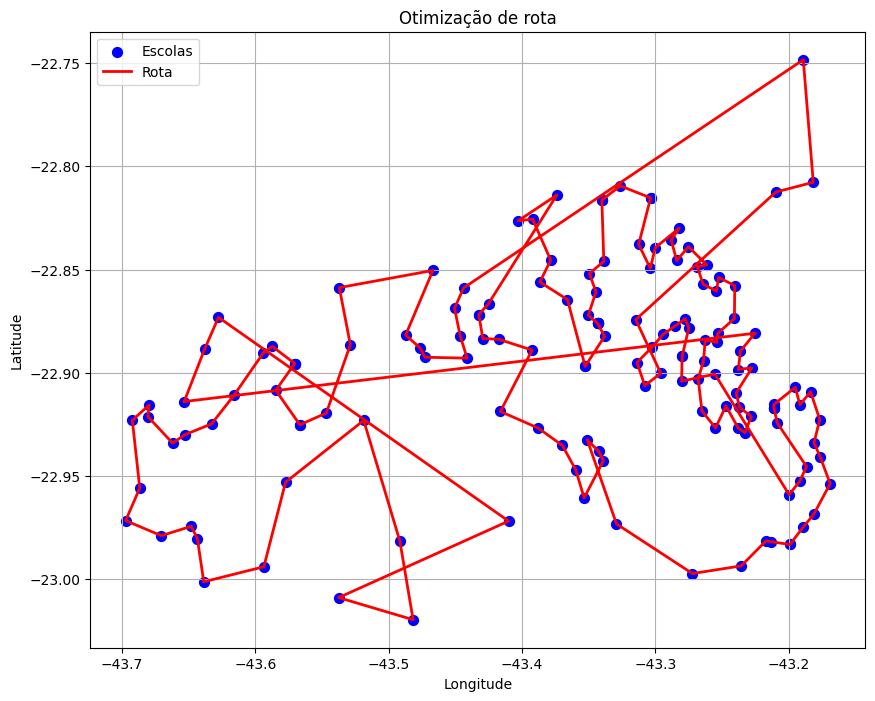

In [29]:
import matplotlib.pyplot as plt

lon_list = rearranged_df['lon']
lat_list = rearranged_df['lat']

# criando o plot
plt.figure(figsize=(10, 8))  # Adjust the figure size if needed

# Criando os pontos dos pares lat/lon e conectando com linha
plt.scatter(lon_list, lat_list, marker='o', s=50, c='blue', label='Escolas')
plt.plot(lon_list, lat_list, marker='', linestyle='-', color='red', linewidth=2, label='Rota')

# Ligando a primeira e a última linha
plt.plot([lon_list[0], lon_list[len(lon_list) - 1]], [lat_list[0], lat_list[len(lat_list) - 1]], marker='', linestyle='-', color='red', linewidth=2)

# Eixos e título
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Otimização de rota')
plt.legend()

# Display
plt.grid(True)
plt.show()